In [2]:
from main import *

In [1]:
bin_data, sin_data = get_data()
bin_p, sin_p = reduce_dim(bin_data, sin_data)
sin_p = generate_data(sin_p, 3, 40000)
images, labels = add_labels(bin_p, sin_p)

(82007,)

In [3]:
model = main(images, labels)

epoch 1


AttributeError: 'baseline' object has no attribute 'conv1'

[10.2851737   4.24479328  0.73271734  0.22036484  0.17937676  0.12559218
  0.07785781  0.06613169  0.03824119  0.02662891]


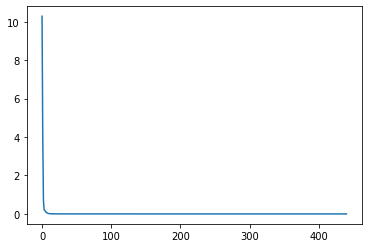

DIMENSIONS:
Cov shape: (441, 441)
E_val shape: (441,)
E values: [[1.02851737e+01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 4.24479328e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 7.32717344e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 2.98001753e-07
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  2.86533420e-07 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 2.59883241e-07]]
E_vec shape: (441, 441)
sort_val shape: (441, 441)
sort_vec shape: (441, 441)
mean shape: (1, 441)
x shape: (42444, 441)
PCA shape: (42444, 2)


RuntimeError: Given groups=1, weight of size [4, 1, 1], expected input[1, 436, 2] to have 1 channels, but got 436 channels instead

In [ ]:
df = sin_df.iloc[:,:441]
num_singles = len(df)
df = df.append(bin_df.iloc[:,:441])
df_p = pd.DataFrame(PCA(df.to_numpy()))
singles = df_p.iloc[:num_singles,:]
singles.insert(2, 'spectral_type', sin_df['spectral_type'], True)
sin_images = singles.iloc[:,:2].to_numpy()  #use in nn
sin_labels = singles.iloc[:,2].to_numpy()   #use in nn

x = torch.from_numpy(sin_images).float()
output_bin = model.forward(x)

In [ ]:
sin_df = pd.read_hdf('/Users/lukemcdermott/Desktop/Physics/spectral_templates_data_version_june20.h5', key = '/singles')
x = sin_df.iloc[:128,:441].to_numpy()
x = torch.from_numpy(x).float()
output_sin = model.forward(x)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (128x441 and 2x1)

In [ ]:
print(output_bin)

tensor([[1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1